In [1]:
import pandas as pd 
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as sns  
import statsmodels.formula.api as smf  
from patsy import build_design_matrices
from scipy import stats


In [2]:
edu_df = pd.read_csv('edu.csv')
edu_df.head()

,Education,Income,Millenial
0,7,19.74,False
1,6,23.70,False
2,9,24.60,False
3,7,25.68,False
4,9,21.71,False


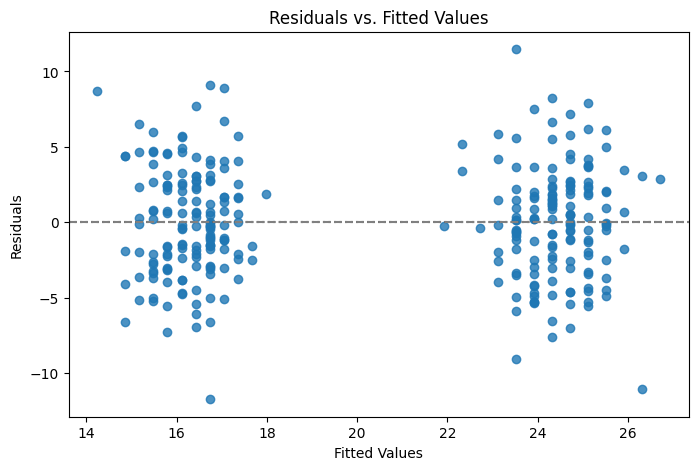

In [7]:
# Fit a linear regression model with Income as the response, Education, Millenial, and their interaction as predictors
model = smf.ols('Income ~ Education * Millenial', data=edu_df).fit()

fitted_values = model.fittedvalues
residuals = model.resid

plt.figure(figsize=(8,5))
sns.residplot(x=fitted_values, y=residuals)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.axhline(0, color='gray', linestyle='dashed')
plt.savefig('plots/residuals_vs_fitted.png')
plt.show()





In [4]:
# 95% confidence interval for the expected income for Millenial residents in the rural area with 8 years of education 
predict_df = pd.DataFrame({'Education': [8], 'Millenial': [True]})
prediction = model.get_prediction(predict_df)
prediction_summary = prediction.summary_frame(alpha=0.05)

mean_pred = prediction_summary['mean'][0]
ci_lower = prediction_summary['mean_ci_lower'][0]
ci_upper = prediction_summary['mean_ci_upper'][0]

print(f"Point estimate: {mean_pred:.2f}")
print(f"95% confidence interval for the expected income of a Millenial resident with 8 years of education: ({ci_lower:.2f}, {ci_upper:.2f})")

Point estimate: 15.48
95% confidence interval for the expected income of a Millenial resident with 8 years of education: (14.59, 16.37)


In [5]:
# 95% CI for difference in incomes: Person c (Millennial, 8 yr edu) vs Person d (Non-millennial, 7 yr edu)
predict_df_two = pd.DataFrame({'Education': [8, 7], 'Millenial': [True, False]})
design_info = model.model.data.design_info
exog_new = build_design_matrices([design_info], predict_df_two)[0]
c = np.asarray(exog_new[0]).ravel()   
d = np.asarray(exog_new[1]).ravel()   
c_minus_d = c - d

beta_hat = model.params.values 
point_estimate = (c_minus_d @ beta_hat) 

# (X^T*X)^(-1)
XtX_inv = model.normalized_cov_params
# Variance of (y*_c - y*_d) - (μ̂_y|c - μ̂_y|d) = 2σ²_ε + σ²_ε (c-d)'(X'X)^{-1}(c-d)
sigma_hat_sq = model.scale  # σ̂²_ε (MSE)
quad = float(c_minus_d @ XtX_inv @ c_minus_d)
var_diff = sigma_hat_sq * (2 + quad)
se_diff = np.sqrt(var_diff)

df_resid = model.df_resid
t_crit = stats.t.ppf(0.975, df_resid)
ci_lower_diff = point_estimate - t_crit * se_diff
ci_upper_diff = point_estimate + t_crit * se_diff

print(f"Person c: Millennial, 8 years education")
print(f"Person d: Non-millennial, 7 years education")
print(f"95% CI for the difference in incomes between Person c and Person d: ({ci_lower_diff:.4f}, {ci_upper_diff:.4f})")

Person c: Millennial, 8 years education
Person d: Non-millennial, 7 years education
95% CI for the difference in incomes between Person c and Person d: (-18.6773, 1.7944)


In [6]:
# c = d ⇒ μ̂_y|c - μ̂_y|d = 0.
# y*_c - y*_d = ε*_c - ε*_d, so Var(y*_c - y*_d) = 2σ²_ε 

sigma_hat = np.sqrt(model.scale)   # σ̂_ε
se_same_covariates = sigma_hat * np.sqrt(2)   # SE of (y*_c - y*_d)  

df_resid = model.df_resid
t_crit = stats.t.ppf(0.975, df_resid)
ci_lower_same = 0 - t_crit * se_same_covariates
ci_upper_same = 0 + t_crit * se_same_covariates

print("Two people with the same Millenial and Education:")
print(f"95% CI for the difference in incomes between two people with the same values of Millenial and Education: ({ci_lower_same:.4f}, {ci_upper_same:.4f})")

Two people with the same Millenial and Education:
95% CI for the difference in incomes between two people with the same values of Millenial and Education: (-10.1738, 10.1738)
